In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models

from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [2]:
device = torch.device('cuda')

In [3]:
def train_transform(sample,padding=200):
    pad_num = np.random.randint(padding)
    sample = torch.cat((torch.zeros((1,pad_num)),sample),-1)
    specgram = torchaudio.transforms.Spectrogram()(sample)
    specgram = (specgram+1e-10).log2()[0,:,:]
    specgram = transforms.Normalize((0.5),(0.5))(specgram.unsqueeze(0)).squeeze(0)
    specgram = torch.stack((specgram,specgram,specgram),dim=0)
    return specgram

def test_transform(sample):
    specgram = torchaudio.transforms.Spectrogram()(sample)
    specgram = (specgram+1e-10).log2()[0,:,:]
    specgram = transforms.Normalize((0.5),(0.5))(specgram.unsqueeze(0)).squeeze(0)
    specgram = torch.stack((specgram,specgram,specgram),dim=0)
    return specgram

In [4]:
a = torch.rand([1, 114561])
train_transform(a).size()

torch.Size([3, 201, 574])

In [5]:
class my_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        sample_1_name = self.df.iloc[idx]['sample 1']
        sample_1_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_1_name
        sample_1,_ = torchaudio.load(sample_1_path)
        
        sample_2_name = self.df.iloc[idx]['sample 2']
        sample_2_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_2_name
        sample_2,_ = torchaudio.load(sample_2_path)
        
        if self.train:
            sample_1_tensor = train_transform(sample_1)
            sample_2_tensor = train_transform(sample_2)
        else:
            sample_1_tensor = test_transform(sample_1)
            sample_2_tensor = test_transform(sample_2)
            
            
        label = self.df.loc[idx,'True or False']
        
        sample = (sample_1_tensor, sample_2_tensor, label)
        return sample

def pad_collate(batch):
    (xx1,xx2, yy) = zip(*batch)
    x1_lens = [len(x[0][0]) for x in xx1]
    x2_lens = [len(x[0][0]) for x in xx2]
    x1_max_len = np.max(x1_lens)
    x2_max_len = np.max(x2_lens)
    
    xx1_new = torch.zeros([len(xx1),xx1[0].size(0),xx1[0].size(1),x1_max_len],dtype=torch.float)
    for i in range(len(xx1)):
        xx1_new[i,:,:,:len(xx1[i][0][0])] = xx1[i]
        
    xx2_new = torch.zeros([len(xx2),xx2[0].size(0),xx2[0].size(1),x2_max_len],dtype=torch.float)
    for i in range(len(xx2)):
        xx2_new[i,:,:,:len(xx2[i][0][0])] = xx2[i]
    
    yy_new = torch.tensor(yy, dtype=torch.long)
    
    sample = {'x1':xx1_new,'x2':xx2_new,'y':yy_new}
    return sample

In [6]:
train_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
BATCH_SIZE = 8
train_sampler = torch.utils.data.sampler.RandomSampler(my_dataset(train_df_path,train = True)\
                                                       ,num_samples=50000,replacement=True)
train_loader = DataLoader(my_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, \
                          sampler = train_sampler,num_workers=16,collate_fn = pad_collate)

val_loader = DataLoader(my_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True,\
                        num_workers=16,collate_fn = pad_collate)

test_loader = DataLoader(my_dataset(test_df_path), batch_size=1, shuffle=False,collate_fn = pad_collate)

In [7]:
iter_ = iter(train_loader)

In [8]:
sample_1 = next(iter_)['x1']
sample_2 = next(iter_)['x2']
sample_1.size()

torch.Size([8, 3, 201, 1550])

In [9]:
next(iter_)['y']

tensor([0, 0, 0, 1, 0, 0, 1, 0])

In [10]:
# resnet18 and remove the final two layers
resnet18 = models.resnet18(pretrained=True)
CNN_model = nn.Sequential(*(list(resnet18.children())[:-1]))
CNN_model[8] = nn.AvgPool2d(7,stride=1)

In [11]:
output_1 = CNN_model(sample_1)
output_1.size()

torch.Size([8, 512, 1, 43])

In [12]:
output_1 = CNN_model(sample_1)
output_1 = output_1.squeeze(2)
output_1 = torch.transpose(output_1,1,2)
output_1.size()

torch.Size([8, 43, 512])

In [13]:
class LSTM(nn.Module):
    def __init__(self, in_dim=512, hidden_dim=128):
        super(LSTM, self).__init__()
        self.lstm_1 = nn.LSTM(in_dim, hidden_dim, batch_first=True)
        self.lstm_2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)
        x = x[:, -1, :]
        return x
RNN_model = LSTM()

In [14]:
RNN_model(output_1).size()

torch.Size([8, 128])

In [15]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = CNN_model
        self.rnn = RNN_model
        self.fc1 = nn.Linear(128*3,1024)
        self.activation_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024,128)
        self.activation_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(128,2)
    
    def forward(self, x1, x2):
        x1 = self.cnn(x1)
        x2 = self.cnn(x2)
        
        x1 = x1.squeeze(2)
        x1 = torch.transpose(x1,1,2)
        x2 = x2.squeeze(2)
        x2 = torch.transpose(x2,1,2)
        
        x1 = self.rnn(x1)
        x2 = self.rnn(x2)
        
        x_add = x1+x2
        x_minus = x1-x2
        x_multiply = x1*x2
        x = torch.cat((x_add, x_minus, x_multiply),-1)
        x = self.fc1(x)
        x = self.activation_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation_fc2(x)
        x = self.fc3(x)
        return x

In [16]:
model = MyModel()

In [17]:
model(sample_1,sample_2).size()

torch.Size([8, 2])

## Train

In [18]:
def train(model, train_loader=train_loader, val_loader=val_loader, learning_rate=1e-4, num_epoch=100):
    start_time = time.time()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    
    train_loss_return = []
    train_acc_return = []
    val_loss_return = []
    val_acc_return = []
    best_acc = 0
    
    for epoch in range(num_epoch):
        # Training steps
        correct = 0
        total = 0
        predictions = []
        truths = []
        model.train()
        train_loss_list = []
        for i, (sample) in enumerate(train_loader):
            sample_1 = sample['x1'].to(device)
            sample_2 = sample['x2'].to(device)
            labels = sample['y'].to(device)
            outputs = model(sample_1,sample_2)
            pred = outputs.data.max(-1)[1]
            predictions += list(pred.cpu().numpy())
            truths += list(labels.cpu().numpy())
            total += labels.size(0)
            correct += (pred == labels).sum()
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            print(loss)
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        # report performance
        acc = (100 * correct / total)
        train_acc_return.append(acc)
        train_loss_every_epoch = np.average(train_loss_list)
        train_loss_return.append(train_loss_every_epoch)
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.4f} | Accuracy: {:4.2f}% '.format(train_loss_every_epoch, acc))
        
        # Evaluate after every epochh
        correct = 0
        total = 0
        model.eval()
        predictions = []
        truths = []
        val_loss_list = []
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                sample_1 = sample['x1'].to(device)
                sample_2 = sample['x2'].to(device)
                labels = sample['y'].to(device)
                outputs = model(sample_1,sample_2)
                loss = loss_fn(outputs, labels)
                val_loss_list.append(loss.item())
                pred = outputs.data.max(-1)[1]
                predictions += list(pred.cpu().numpy())
                truths += list(labels.cpu().numpy())
                total += labels.size(0)
                correct += (pred == labels).sum()
            # report performance
            acc = (100 * correct / total)
            val_acc_return.append(acc)
            val_loss_every_epoch = np.average(val_loss_list)
            val_loss_return.append(val_loss_every_epoch)
            if acc > best_acc:
                best_acc = acc
                best_model_wts = model.state_dict()
            save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts)
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Loss: {:6.4f} | Accuracy: {:4.2f}% | time elapse: {:>9}'\
                  .format(val_loss_every_epoch, acc,elapse))
    return model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts

def save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, 'checkpoint_CNN_LSTM.pt')
    return None

In [19]:
model = MyModel().to(device)

In [20]:
train(model)

tensor(0.6876, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7027, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6814, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7084, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7046, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward

KeyboardInterrupt: 

## Evaluate

In [18]:
model = MyModel().to(device)

In [19]:
model.load_state_dict(torch.load('/scratch/cz2064/myjupyter/Time_Series/notebook/python_files/\
CNN_LSTM_Spectrogram_2/Second_Train/checkpoint_CNN_LSTM.pt',map_location=torch.device(device))['best_model_wts'])

<All keys matched successfully>

In [20]:
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
test_loader = DataLoader(my_dataset(test_df_path), batch_size=1, shuffle=False,collate_fn = pad_collate)

In [21]:
def evaluate_model(model, dataloader):   
    model.eval()
    y_true = []
    y_score = []
    y_pre = []
    
    model.eval()
    for i,(sample) in enumerate(dataloader):

        sample_1 = sample['x1'].to(device)
        sample_2 = sample['x2'].to(device)
        label = sample['y'].to('cpu',dtype=torch.long)
        y_true += label.tolist()

        output = model(sample_1,sample_2)
        output = F.softmax(output,dim=1)
        output = output.to('cpu')
        if y_score == []:
            y_score = np.array(output.detach().numpy())
        else:
            y_score = np.concatenate((y_score,output.detach().numpy()),axis = 0)
    for i in y_score:
        y_pre.append(list(i).index(max(i)))
    return y_true,y_pre,y_score

In [22]:
y_true,y_pre,y_score = evaluate_model(model, test_loader)

In [23]:
test_df = pd.read_csv(test_df_path)
test_df['pre'] = y_pre
test_df['score'] = np.expand_dims(np.array(y_score),2)[:,1]

In [24]:
test_df.head()

,True or False,sample 1,sample 2,pre,score
0,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00008.wav,1,9.885612e-01
1,0,id10270/x6uYqmx31kE/00001.wav,id10300/ize_eiCFEg0/00003.wav,0,1.086153e-07
2,1,id10270/x6uYqmx31kE/00001.wav,id10270/GWXujl-xAVM/00017.wav,1,9.980960e-01
3,0,id10270/x6uYqmx31kE/00001.wav,id10273/0OCW1HUxZyg/00001.wav,0,3.541488e-02
4,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00022.wav,1,9.944252e-01


In [25]:
test_df.to_csv('Pre_CNN_LSTM.csv', index = False)

In [26]:
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None

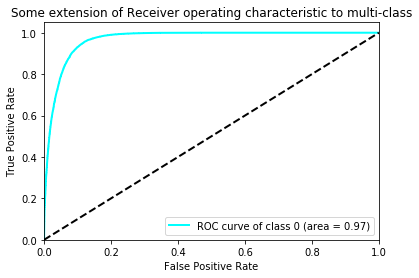

In [27]:
ROC_curve(np.expand_dims(np.array(y_true),1),np.expand_dims(np.array(y_score),2)[:,1])